# Optimal Transport


In [1]:
pip install POT

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.optimize import linprog
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

## Background

Optimal transport is in the scope of network flow where we have a sets of source nodes and target nodes. The source nodes only go through target nodes, which means souce nodes cannot go to other source nodes and target nodes only receive the flows. The goal of optimal transport is to find the minimum cost to move mass from source nodes to target nodes.

In the 20th century, mathematician Monge introduced Monge Formulation, that is mapping the transportation from places to places. Intutively, if we have a source node $\mathbf{s}$ with mass $\mathbf{M}$ and a target node $\mathbf{T(s)}$. We would like to transfer the $\mathbf{M}$ from $\mathbf{s}$ to $\mathbf{T(s)}$ (Flamary & Courty, 2019). In order to perform an optimal transport, we proceed:

1. Calculate the Distance between $\mathbf{T(s)}$ and $\mathbf{s}$. That is $\mid \mathbf{s}-\mathbf{T(s)}\mid $.
2. Find the minimum cost to move the mass $\mathbf{M}$. That is we are going to minimize $\mid \mathbf{s}-\mathbf{T(s)}\mid $.

The graph visualization of Monge Formulation is found below:

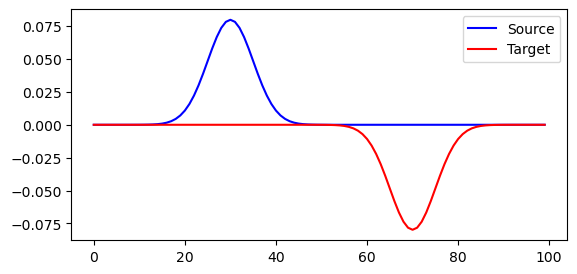

In [20]:
n = 100
x = np.arange(n, dtype=np.float64)
a = gauss(n, m=30, s=5)
b = -gauss(n, m=70, s=5)
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
plt.figure(1, figsize=(6.4, 3))
plt.plot(x, a, 'b', label='Source')
plt.plot(x, b, 'r', label='Target')
plt.legend()

The plot visualize the transportation from source to target. We can imagine source as dirt and target as hole. The target is to transport all the dirt from the blue upper-line area to the hole at the bottom red-line area. That is equally costly to move dirt from source to target. In mathematics notation:

$$ \text{infimum} \int c(s,t) \mu_s(x)ds $$

* Probability measures $\mu_s$ and $\mu_p$, and c is the cost matrix that measures the distance between source and target ($ c:\Omega_s \times \Omega_t, c \in R$)

Optimal transport has wide ranges in many applications and progresses through these years all the time. We will consider some special cases of optimal transport in this artifact.

## 2D Optimal Transport between Discrete Points

### Intuition
In this case study, we are going to focus on the optimal transport between discrete distributions of nodes. Since optimal transport is a board topic contains many cases. We look at the optimal transport in 2-D planes for better visualization. Usually, we will build a linear optimization system for solving these problems. 

Set $\mathbf{s}_1,\dots,\mathbf{s}_{n_s} \in \mathbf{R}^2$ be $n_s$ source nodes
* Set $\mathbf{t}_1,\dots,\mathbf{t}_{n_t} \in \mathbf{R}^2$ be $n_t$ target nodes 
* Let $m_{\mathbf{s}_1},\dots,m_{\mathbf{s}_{n_s}}$ be the masses of the source nodes
* Let $m_{\mathbf{t}_1},\dots,m_{\mathbf{t}_{n_t}}$ be the masses of the target nodes
* The total mass of source nodes should be $\sum_{i=1}^{n_s} m_{\mathbf{s}_i} = 1$
* The total mass of target nodes should be $\sum_{j=1}^{n_t} m_{\mathbf{t}_j} = 1$

The goal is to minimize the total cost of transportation of moving the masses from all the $\mathbf{s}$ to all the $\mathbf{t}$. Then we can start to build up an optimal transport problem:

* Design a cost matrix that takes all distances between all source-target node pairs.
* Set up decision variables and constraints in matrix form A and b.
* Set up a linear system $A \mathbf{x} = \mathbf{b}$ and solve it with linprog.


We will try to interpret how a simple optimal transport works for a problem with two source nodes and two target nodes.

### Case Study
#### Define Source Nodes and Target Nodes

In [21]:
sources = np.array([(0,1,1/2),(1,0,1/2)])
targets = np.array([(2,1,1/3),(3,3,2/3)])

Define the source nodes as sources and the target nodes as targets. Both source nodes and target nodes take three elements: 
* x-coordinate
* y-coordiante
* weight proportion

Return them to arrays and we plot those nodes.

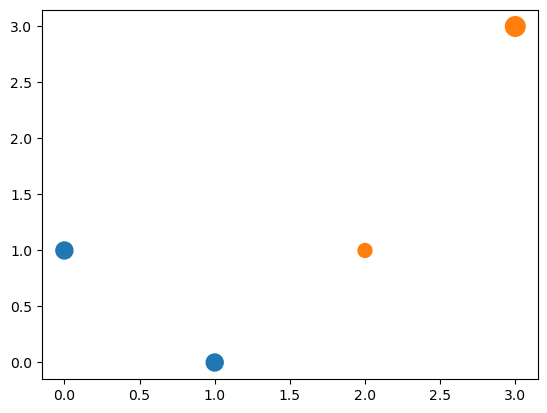

In [22]:
plt.scatter(sources[:,0],sources[:,1],s=300*sources[:,2])
plt.scatter(targets[:,0],targets[:,1],s=300*targets[:,2])
plt.show()

#### Define Cost Matrix

In [23]:
ns = sources.shape[0]
nt = targets.shape[0]
C = np.zeros((ns,nt))
for i in range(0,ns):
    for j in range(0,nt):
        C[i,j] = la.norm(sources[i,[0,1]] - targets[j,[0,1]])

Cost matrix aims to generate the distance between the source node and target node. Here we permutate all possible routes using a double-for loop. In the for loop, we would like to get the distance between souce node i and target node j. After getting all possible distances between all node-pairs, we write it down as a matrix.

In [24]:
C

array([[2.        , 3.60555128],
       [1.41421356, 3.60555128]])

All the elements in this cost matrix are the distances from a source-target node pair. For example, the first element is distance between the 'source1' and 'target1'.

#### Set Up an Linear Programming

Since we have defined the cost matrix, we could apply linear programming for optimal transport problems if we have a decesion variable matrix and a constraint matrix. Here we can treat:
* A as Decision Variables
* b as Constraints

In [25]:
def A(ns,nt):
    mA = np.zeros((ns + nt,ns*nt))
    for i in range(0,ns):
        mA[i,i*nt:(i+1)*nt] = np.ones(nt)
        mA[ns:,i*nt:(i+1)*nt] = np.eye(nt)
    return mA

In [26]:
A=A(2,2)
A

array([[1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]])

'MatrixA' is a $n_s \times n_t$ for optimal transport for $n_s$ source nodes and $n_t$ target nodes.

In [27]:
b = np.hstack([sources[:,2],targets[:,2]])
b

array([0.5       , 0.5       , 0.33333333, 0.66666667])

'Matrixb' gives the weights for all source nodes and target nodes.

Then we can use linear programming solver to solve this problem.

In [28]:
## Set Up a linear Programming in linprog
solution = linprog(C.flatten(),A_eq=A[1:],b_eq=b[1:])

#### Output

In [29]:
print(solution.message)
print(solution.x)

Optimization terminated successfully. (HiGHS Status 7: Optimal)
[0.         0.5        0.33333333 0.16666667]


The output indicates that we have an optimal solution. Notice that we have an array 'x' that takes the transportation proportion of each source-target pair. In this particular example, to achieve an optimal solution for optimal transport, we have to transport for cost savings:

* 0%     -- From Source1(0,1) to Target1(2,1)
* 50% -- From Source1(0,1) to Target2(3,3)
* 33.33% -- From Source2(1,0) to Target1(3,3)
* 16.67%    -- From Source2(1,0) to Target2(3,3)

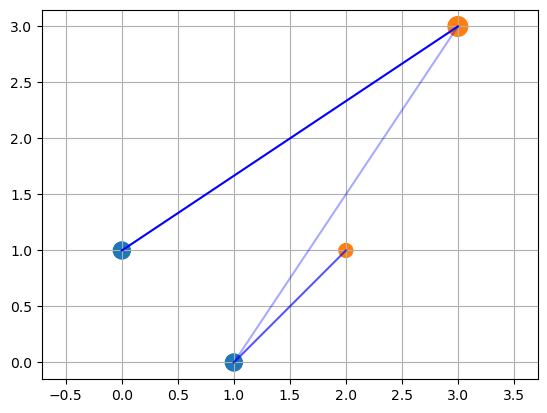

In [30]:
plt.scatter(sources[:,0],sources[:,1],s=300*sources[:,2])
plt.scatter(targets[:,0],targets[:,1],s=300*targets[:,2])
flow = solution.x.reshape((ns,nt))
for i in range(0,ns):
    for j in range(0,nt):
        if np.round(flow[i,j],2) > 0:
            plt.plot([sources[i,0],targets[j,0]],[sources[i,1],targets[j,1]],'b',alpha=flow[i,j]/np.max(flow))

plt.axis("equal"), plt.grid(True)
plt.show()

To visualize with a graph and combine the numerical outputs, the optimal solution indicates the transportating allocation to move the stuff from source nodes to target nodes. The dense blue line suggests a higher proportion of transportation proportion than light lines. To explain how the graph works, all the materials(50% of the total materials) in source1(1,0) has been transfered to target2(3,3). But target2(3,3) still needs 16.67% of the total materials to reach its capcity. Thus, source2(0,1) transports 16.67% of the total materials to targe2(3,3). The rest remaining is transported to target1(2,1). We can see that the total weight of materials is the same and each target receives proper proportions, and this is an optimal transport problem where the routes to deliver all the materials like the plot illustrated is the cost-minizing. 

## 2-D Empirical Distributions

For multiple nodes, if draw lines between each source-target pair, the results will be difficult to interpret. Thus, consider empirical distributions in the form of 2-D. We can design an image recognition for multiple nodes. The solver is imported from the python optimal transport website (https://pythonot.github.io/index.html).

### Generate Data

In [101]:
## number of nodes
n = 100

## mean of nodes
mu_s = np.array([0, 0])
## covariance of nodes
cov_s = np.array([[1, 0.4], [0.4, 1]])

mu_t = np.array([5, 5])
cov_t = np.array([[0.8, -0.5], [-0.5, 0.8]])

First, we create 100 source nodes and 100 target nodes. Then we assign the mean and covariances arrays(2-D) for both source and target nodes. 

In [102]:
ns = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
nt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

Then we apply datasets.make_2D_samples_gauss in the ot package for pythonot. It takes 3 arguments: sample size, mean and covariances for nodes and output the locations for nodes in (x,y) coordinates.

In [103]:
a, b = np.ones((n,)) / n, np.ones((n,)) / n 

We create two uniform distributions for this sample.

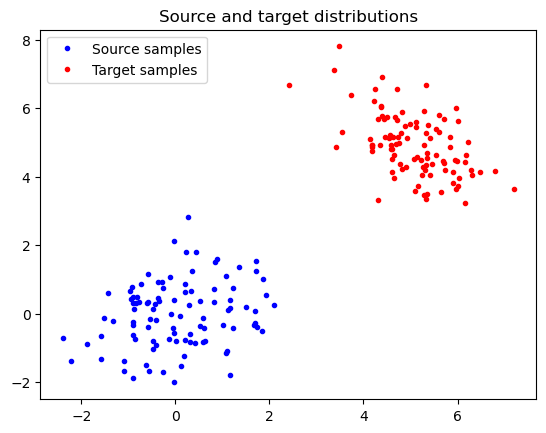

In [104]:
plt.plot(ns[:, 0], ns[:, 1], '.b', label='Source samples')
plt.plot(nt[:, 0], nt[:, 1], '.r', label='Target samples')
plt.legend(loc=0)
plt.title('Source and target distributions')
plt.show()

### Create Cost Matrix

In [105]:
M = ot.dist(ns, nt)

In [107]:
M

array([[76.45000332, 60.58869117, 83.66413778, ..., 57.72536496,
        53.45879867, 70.34907029],
       [78.82814698, 62.14948254, 84.76832397, ..., 59.69928067,
        55.18274438, 72.16383403],
       [39.7746511 , 31.42726975, 53.03055767, ..., 27.12591825,
        25.08594581, 37.64543286],
       ...,
       [52.79075778, 43.45120615, 67.95381624, ..., 38.21390251,
        35.91397748, 50.71314872],
       [69.34993715, 60.44181821, 89.70755337, ..., 53.10427783,
        50.99323233, 68.53274597],
       [57.709596  , 44.28521461, 65.31849922, ..., 41.60676184,
        38.04262802, 52.56355099]])

Design the cost matrix using python code ot.dist. It takes the arguments of source nodes and target nodes to produce a matrix with transcation costs.

### Output

In [108]:
G0 = ot.emd(a, b, M)

The solver is in the Python Optimal Transport (POT) library. The term 'emd' represents for Earth Mover's Distance. It is a metric of particle collider events. The emd between the two events is the minimum work required to rearrange one event(a) to another event(b) by movements of weights from particle 1 in one event(a) to particle 2 in the another event(b) (Patrick, 2021).

In this case, the ot.emd takes three arguments: weight partitions for source nodes, target nodes and the cost matrix M. It will give values for optimal transport plan in a matrix form.

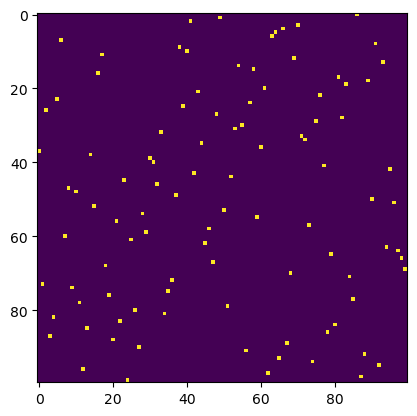

In [110]:
plt.imshow(G0, interpolation='nearest')
plt.show()

Here is the visualization for the G0 matrix. Notice that the purple part in the matrix corresopnd to the area when G0 outputs 0 for particular [row i, column j]. For example, the top left corner is purple and that means the first element in the first row, first column is 0.

The yellow part is what we are looking for, which are the peaks in the G0 matrix. It provides us a transport plan for in a 2-D format. We could take the inner product between matrix G0 and coat matrix M and then take the square root to arrive at the Wasserstein distance between the source and target. However, this plot is still hard to interpret, but gives a better visualization than the discrete lines if there are hundreds of nodes.

## 1-D Probability Mass Functions

### Intuition

Other than the 2-D distribution for visualizaiton, we can also apply optimal transport for probability mass functions in 1-D problems. Intuitively, the nodes are no longer discrete with certain coordinates due to the properties of these functions. A density function is a smoothed, continuous estimation of the data. In this case, we can treat it as a continuous optimal transport problem. To visualize the transport plan, we use the image and create the transport route.
#### Generate Data

In [42]:
n = 100
x = np.arange(n, dtype=np.float64)

n equals to the number of nodes. x is the location of nodes.

In [43]:
a = gauss(n, m=30, s=10)
b = gauss(n, m=70, s=20)

a is the source distribution, b is the target distribution. m is the mean of distribution, s is the standard deviation of distribution.

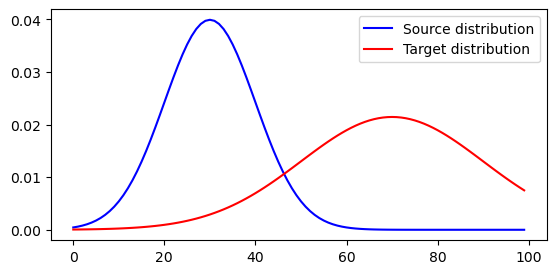

In [44]:
plt.figure(1, figsize=(6.4, 3))
plt.plot(x, a, 'b', label='Source distribution')
plt.plot(x, b, 'r', label='Target distribution')
plt.legend()

The diagram shows a standard probability mass functions defined on the interval [0,1]. We would like to design a cost matrix using the function in Python Optimal Transport package. The function is called ot.plot.plot1D_mat, which takes the two probability mass functions to generate a cost matrix as below.

#### Cost Matrix

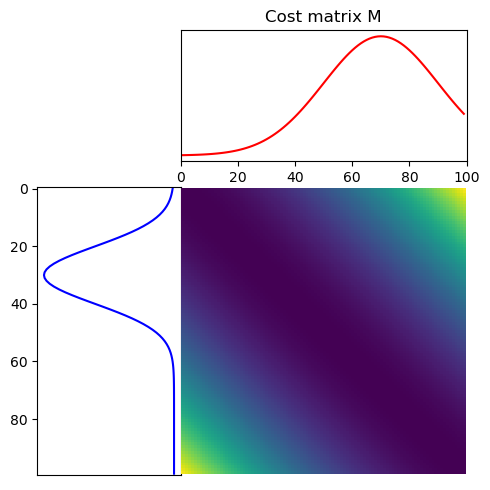

In [45]:
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
plt.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M, 'Cost matrix M')

Visualizing the the plot, we have seperate the two distributions along with the same density functions. The cost is zero along the diagonal of the cost matrix C since it doesn't cost anything to move the mass zero units of distance. The transportation cost in this problem is counted as squared Euclidean distance, which means moving vertically or horizontally off the diagonal can increase the transcational cost quadratically.

#### Problem Solving and Result

In [34]:
G0 = ot.emd(a, b, M)

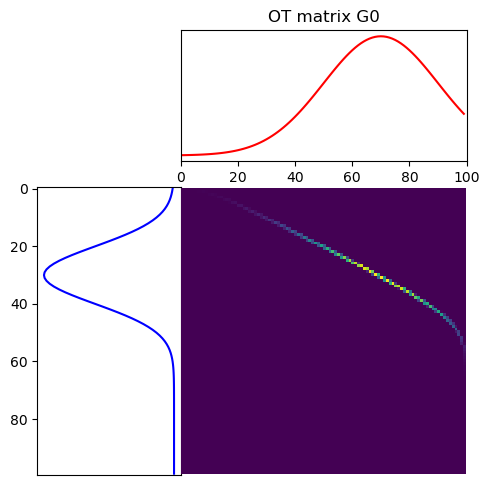

In [35]:
plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, G0, 'OT matrix G0')

The purple plot above is a transport plan matrix, where is solved by the 1-D optimal transport solver. The matrix entry (i,j) tells how much mass from i in the source should be transported to j in the target. The matrix itself is sparse because we can only see a very thin curve. The curved path comes from the upper left corner to the middle right. This curve means the masses at two nearby locations have a relatively similar transport cost no matter what destination we choose because the cost has a positive propotional trend with mass. The transportation cost increases as the probability mass increases, and that satisfied with our theory. 

The parts with yellow colors on the curve correspond to peaks in the marginal densities. If we refer to the two probability mass functions on the top and left, the yellow parts can take more mass capacity than the darker blue regions. That is the constraints during the transportation becuase we cannot exceed the limit of these mass functions.

In additon, the line is above the diagonal, because most of the mass densities in the source is to the right of the mass densities in the target.

## Conclusion
Now we have seen two special cases for optimal transport. The procedures for both of the cases are based on linear programming. The results are quite different because of the type of data presented. Optimal transport is an abstract concept especially when the data is continuous, we are hard to visualize the results even we have an image. For discrete nodes, the interpretaions are not that hard to interpret but we can get into a mess when there are complicated situaions with hundreds of source-target pairs, but the basic ideas for all optimal transport problems are similar. In general, optimal transport can be easier to visualize with the help of images to find the cost-minimzing transport plan for moving masses from source to target. 

## References

Flamary, R., &amp; Courty, N. (2019, April 8). Optimal transport for machine learning. Retrieved December 9, 2022, from https://remi.flamary.com/cours/otml/OTML_ISBI_2019_OTintro.pdf 

Patrick T. Komiske III, E. M. M. (2021). Energy Mover's distance. EnergyFlow. Retrieved December 9, 2022, from https://energyflow.network/docs/emd/ 

Pot: Python optimal transport. POT: Python Optimal Transport - POT Python Optimal Transport 0.8.2 documentation. (n.d.). Retrieved December 9, 2022, from https://pythonot.github.io/index.html 